# Model 01

Get to a model as soon as possible... we'll us `DummyRegressor` to make this happen:

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor

df = pd.read_csv('data/weather_power.csv')

target = 'energy_demand'
y = df[target]
X = df[['temperature']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

model = DummyRegressor()
model.fit(X_train, y_train)

DummyRegressor()

`DummyRegressor` will literally just predict the average for everything... doesn't matter what you put in:

In [2]:
model.predict(X_test)

array([5692.04161844, 5692.04161844, 5692.04161844, ..., 5692.04161844,
       5692.04161844, 5692.04161844])

Score the model to get a number to beat:

In [3]:
from sklearn.metrics import mean_squared_error

round(mean_squared_error(y_test, model.predict(X_test)) ** (1/2))

1451.0

Predict one:

In [4]:
X.sample(1).to_dict(orient='list')

{'temperature': [24.6]}

I like to take that and embed it in a new pandas.DataFrame:

In [5]:
new = pd.DataFrame({'temperature': [21]})
model.predict(new)[0]

5692.041618441358

Save the model so that we can wrap an app around the serialized version:

In [6]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

Make sure it works:

In [7]:
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

model.predict(new)[0]

5692.041618441358

# App 01

Just a shitty hello world example with Flask:

In [8]:
%%writefile app.py

from flask import Flask

app = Flask(__name__)

@app.route('/')
def index():
    return 'Hello'

if __name__ == '__main__':
    app.run(port=5000, debug=True)

Overwriting app.py


Run at the command line:

In [ ]:
!python app.py

Interrupt when finished to move on...

# App 02

Extend the hello world example and add the model in... (this will break):

In [9]:
%%writefile app.py

import pickle

from flask import Flask
import pandas as pd

app = Flask(__name__)

with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

@app.route('/')
def index():
    new = pd.DataFrame({'temperature': [20]})
    prediction = model.predict(new)
    print(prediction)
    return prediction

if __name__ == '__main__':
    app.run(port=5000, debug=True)

Overwriting app.py


In [10]:
!python app.py

 * Serving Flask app "app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 122-223-301
[5692.04161844]
127.0.0.1 - - [21/Aug/2020 14:02:45] "GET / HTTP/1.1" 500 -
Traceback (most recent call last):
  File "/Users/max/opt/miniconda3/lib/python3.8/site-packages/flask/app.py", line 2464, in __call__
    return self.wsgi_app(environ, start_response)
  File "/Users/max/opt/miniconda3/lib/python3.8/site-packages/flask/app.py", line 2450, in wsgi_app
    response = self.handle_exception(e)
  File "/Users/max/opt/miniconda3/lib/python3.8/site-packages/flask/app.py", line 1867, in handle_exception
    reraise(exc_type, exc_value, tb)
  File "/Users/max/opt/miniconda3/lib/python3.8/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/Users/max/opt/miniconda3/lib/python3.8/site-packages/flask/app.p

**TypeError** 

> TypeError: The view function did not return a valid response. The return type must be a string, dict, tuple, Response instance, or WSGI callable, but it was a ndarray.  

# App 03

Fix the return type by returning a dictionary:

In [12]:
%%writefile app.py

import pickle
from flask import Flask
import pandas as pd

app = Flask(__name__)

with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

@app.route('/')
def index():
    new = pd.DataFrame({'temperature': [20]})
    prediction = model.predict(new)[0]
    # return str(prediction)
    return {'prediction': prediction}

if __name__ == '__main__':
    app.run(port=5000, debug=True)

Overwriting app.py


Alternatively, you could `return str(prediction)`

Run the app:

In [13]:
!python app.py

 * Serving Flask app "app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 122-223-301
127.0.0.1 - - [21/Aug/2020 14:05:18] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2020 14:05:18] "GET /?__debugger__=yes&cmd=resource&f=style.css HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2020 14:05:18] "GET /?__debugger__=yes&cmd=resource&f=jquery.js HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2020 14:05:18] "GET /?__debugger__=yes&cmd=resource&f=debugger.js HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2020 14:05:18] "GET /?__debugger__=yes&cmd=resource&f=ubuntu.ttf HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2020 14:05:18] "GET /?__debugger__=yes&cmd=resource&f=console.png HTTP/1.1" 200 -
^C


# App 04

Introducing query params... they look like `http://website.com/endpoint?query=string`. In order to capture, we need the `flask.request` object which will let us peel off `request.args` which is basically just a dictionary:

In [14]:
%%writefile app.py

import pickle
from flask import Flask, request
import pandas as pd

app = Flask(__name__)

with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

@app.route('/')
def index():
    return 'Use the /predict endpoint'

@app.route('/predict')
def predict():
    query = request.args
    print(query)
    new = pd.DataFrame({'temperature': [20]})
    prediction = model.predict(new)[0]
    return {'prediction': prediction}

if __name__ == '__main__':
    app.run(port=5000, debug=True)

Overwriting app.py


Run and watch the command line when you enter arbitrary query strings like:
    
- http://127.0.0.1:5000/predict?hi=there&name=max
- http://127.0.0.1:5000/predict?even=more&query=strings
- http://127.0.0.1:5000/predict?temperature=25

In [16]:
!python app.py

 * Serving Flask app "app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 122-223-301
127.0.0.1 - - [21/Aug/2020 14:08:43] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2020 14:08:43] "GET /?__debugger__=yes&cmd=resource&f=style.css HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2020 14:08:43] "GET /?__debugger__=yes&cmd=resource&f=debugger.js HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2020 14:08:43] "GET /?__debugger__=yes&cmd=resource&f=jquery.js HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2020 14:08:43] "GET /?__debugger__=yes&cmd=resource&f=console.png HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2020 14:08:43] "GET /?__debugger__=yes&cmd=resource&f=ubuntu.ttf HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2020 14:08:45] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2020 14:08:45] "GET /?__debugger__=yes&cmd=resource&f=style.css HTTP/1.1" 200 -

Will return `ImmutableMultiDict([('hi', 'there'), ('name', 'max')])` which is just a fancy dictionary

# App 05 

Actually connect the temperature query string to the model:

In [17]:
%%writefile app.py

import pickle
from flask import Flask, request
import pandas as pd

app = Flask(__name__)

with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

@app.route('/')
def index():
    return 'Use the /predict endpoint'

@app.route('/predict')
def predict():
    query = request.args
    temperature = float(query.get('temperature'))
    print(temperature)
    new = pd.DataFrame({'temperature': [temperature]})
    prediction = model.predict(new)[0]
    return {'prediction': prediction}

if __name__ == '__main__':
    app.run(port=5000, debug=True)

Overwriting app.py


Run at the command line:

In [19]:
!python app.py

 * Serving Flask app "app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 122-223-301
25.0
127.0.0.1 - - [21/Aug/2020 14:12:32] "GET /predict?temperature=25 HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2020 14:12:32] "GET /favicon.ico HTTP/1.1" 404 -
50.0
127.0.0.1 - - [21/Aug/2020 14:12:36] "GET /predict?temperature=50 HTTP/1.1" 200 -
^C


And hit the url with some temperatures:

- http://127.0.0.1:5000/predict?temperature=25

Trying different temperatures won't actually do anything because we're using a dummy model! Let's fix that...

# Model 02

Try a simple linear regression:

In [21]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

This will break because our data has some NaNs...

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23040 entries, 0 to 23039
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           23040 non-null  object 
 1   temperature    22873 non-null  float64
 2   energy_demand  23040 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 540.1+ KB


# Model 03

We can fix this problem with `DataFrameMapper`:

In [25]:
from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper

mapper = DataFrameMapper([
    ('temperature', SimpleImputer())
], df_out=True)

mapper.fit_transform(X_train)

ValueError: temperature: Expected 2D array, got 1D array instead:
array=[-16.9 -16.3 -17.6 ...   9.1   8.7   8.3].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

**Value Error**

> ValueError: temperature: Expected 2D array, got 1D array instead:

DataFrameMapper is a little finicky when it comes to number vs string columns... which is actually scikit-learn's fault!

Quickly fixed by wrapping that column in square brackets (not always)... it has to do with the difference between a column and a Series:

In [27]:
mapper = DataFrameMapper([
    (['temperature'], SimpleImputer())
], df_out=True)

mapper.fit_transform(X_train)

,temperature
0,-16.9
1,-16.3
2,-17.6
3,-18.6
4,-17.8
...,...
20731,10.3
20732,9.5
20733,9.1
20734,8.7


# Model 04

Transform the data into `Z_` objects... my short-hand for "HEY I DID SOMETHING TO THIS!~"

In [29]:
Z_train = mapper.fit_transform(X_train)
Z_test = mapper.transform(X_test)

model = LinearRegression()
model.fit(Z_train, y_train)

LinearRegression()

Score it:

In [30]:
round(mean_squared_error(y_test, model.predict(Z_test)) ** (1/2))

1345.0

Slightly beats the dummy, but not by much. Let's look at some examples:

In [31]:
pd.DataFrame({
    'y_true': y_test,
    'y_hat': model.predict(Z_test)
}).sample(25)

,y_true,y_hat
20850,4933,5761.345300
20781,4803,5761.345300
22335,7489,5938.386157
21884,7030,5919.206731
22336,7508,5938.386157
21449,5661,5821.834260
21485,3706,5728.887810
21538,5898,5882.323219
21792,5009,5867.569814
22479,7819,6006.251819


# Model 05

In order to save we have to serialize the mapper and the model:

In [35]:
with open('mapper.pkl', 'wb') as f:
    pickle.dump(mapper, f)
    
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

Not super ideal... because we have to keep track of two things.

In [37]:
with open('mapper.pkl', 'rb') as f:
    mapper = pickle.load(f)

with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

Try and predict one...

In [40]:
X_train.sample(1).to_dict(orient='list')

{'temperature': [7.5]}

In [41]:
new = pd.DataFrame({'temperature': [21]})

Z_new = mapper.transform(new)
model.predict(Z_new)[0]

5879.372538053129

But less is more, so I think we can do better...

# Model 06

Build a pipeline... so that we only have to manage one thing, and so that we can get rid of the intermediate `Z` objects:

In [44]:
from sklearn.pipeline import make_pipeline

In [46]:
pipe = make_pipeline(mapper, model)
pipe.fit(X_train, y_train);

Dump:

In [47]:
with open('pipe.pkl', 'wb') as f:
    pickle.dump(pipe, f)

And load:

In [48]:
with open('pipe.pkl', 'rb') as f:
    pipe = pickle.load(f)

In [49]:
pipe.predict(new)[0]

5879.372538053129

For deploying... we'll actually need our full model to be in a file, so let's do that now:

In [50]:
%%writefile model.py

import pickle
import pandas as pd
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

df = pd.read_csv('data/weather_power.csv')

target = 'energy_demand'
y = df[target]
X = df[['temperature']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

mapper = DataFrameMapper([
    (['temperature'], SimpleImputer())
], df_out=True)

model = LinearRegression()

pipe = make_pipeline(mapper, model)
pipe.fit(X_train, y_train)

with open('pipe.pkl', 'wb') as f:
    pickle.dump(pipe, f)

Overwriting model.py


# Deploy 01

On Heroku

1. Setup a virtual environment:

```
python -m venv .venv
```

2. Activate it:

```
source .venv/bin/activate
```

3. Install app and model dependencies (`gunicorn` is for in between the web and flask):

```
pip install gunicorn flask scikit-learn pandas sklearn_pandas
```

3. Freeze the dependencies:

```
pip freeze > requirements.txt
```

4. Retrain the model inside of the virtual environment:

```
python model.py
```

5. Make sure the app still works locally:

```
python app.py
```

6. Specify a python runtime (3.8 not working yet):

```
python --version
echo "python-3.7.9" > runtime.txt
```

7. Create a `Procfile`:

```
echo "web: gunicorn app:app" > Procfile
```

8. (Optional) If your project isn't already a git repo, make it one:

```
git init
touch .gitignore
echo ".venv" >> .gitignore
```

9. Login to Heroku from the [command line](https://devcenter.heroku.com/articles/heroku-cli):

```
heroku login
```

10. Create a project:

```
heroku create
```

11. Add a remote to the randomly generated project:

```
heroku git:remote -a silly-words-009900
```

12. Test the app locally:

```
heroku local
```

13. add, commit push:

```
git add .
git commit -m '🚀'
git push heroku master
```

14. Hit the url and make sure it works!

- http://\<url\>/predict?temperature=20

15. Make sure nothing is wrong (check the logs!):

```
heroku logs -t 
```

# App 07

FastAPI is the new kid on the block. It's faster, less boilerplate, and the future. Converting from Flask to FastAPI isn't that tough:

In [53]:
%%writefile app.py

import pickle
import pandas as pd

import uvicorn
from fastapi import FastAPI

app = FastAPI()

with open('pipe.pkl', 'rb') as f:
    pipe = pickle.load(f)

@app.get('/')
def index():
    return 'Use the /predict endpoint with a temperature argument'

@app.get('/predict')
def predict(temperature: float):
    new = pd.DataFrame({'temperature': [temperature]})
    prediction = pipe.predict(new)[0]
    return {'prediction': prediction}

if __name__ == '__main__':
    uvicorn.run(app)

Overwriting app.py


Run at the command line with:

In [54]:
!uvicorn app:app --port 5000 --reload

INFO:     Uvicorn running on http://127.0.0.1:5000 (Press CTRL+C to quit)
INFO:     Started reloader process [5353] using statreload
INFO:     Started server process [5355]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     127.0.0.1:54477 - "GET /predict?temperature=20 HTTP/1.1" 200 OK
INFO:     127.0.0.1:54477 - "GET /predict?temperature=20 HTTP/1.1" 200 OK
INFO:     127.0.0.1:54478 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:54478 - "GET /openapi.json HTTP/1.1" 200 OK
^C
INFO:     Shutting down
INFO:     Finished server process [5355]


Try it out and make sure it still works:

- http://127.0.0.1:5000/predict?temperature=20

As a bonus there's also some wicked auto-generate docs at:

- http://127.0.0.1:5000/docs

Interrupt and kill when you've verified it works

# Deploy 02

Heroku + fastAPI

0. If you're not in your environment anymore you can re-enter with:

`source .venv/bin/activate`

(And to exit out to your base environment):

`deactivate`

1. Install the new dependencies:

```
pip install uvicorn fastapi
```

2. Freeze the dependencies:

```
pip freeze > requirements.txt
```

3. Retrain the model inside of the virtual environment:

```
python model.py
```

4. Make sure the app still works locally:

```
uvicorn app:app --port=5000
```

5. Create a new `Procfile`:

```
echo "web: uvicorn app:app --host=0.0.0.0 --port=${PORT:-5000}" > Procfile
```

6. Test the app locally:

```
heroku local
```

7. add, commit push:

```
git add .
git commit -m '🚀'
git push heroku master
```

8. Click on the url and make sure it works!

- http://\<url\>/predict?temperature=20

# Model 07

The model we have right now sucks...

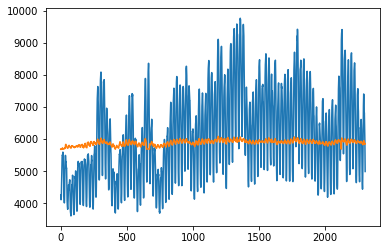

In [57]:
from matplotlib import pyplot as plt

plt.plot(range(len(y_test)), y_test)
plt.plot(range(len(y_test)), model.predict(Z_test));

It barely explains anything... but it actually turns temperature can explain a lot when we properly handle the column...

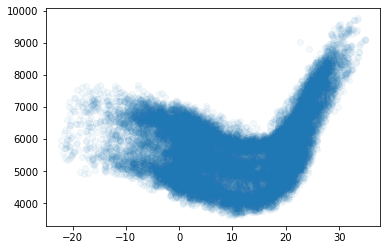

In [59]:
plt.scatter(df['temperature'], df['energy_demand'], alpha=1/20);

Whenever we see a "U" or a rainbow, we should look at brining in Polynomial Features

In [60]:
from sklearn.preprocessing import PolynomialFeatures

mapper = DataFrameMapper([
    (['temperature'], [SimpleImputer(), PolynomialFeatures(degree=2, include_bias=False)])
], df_out=True)

mapper.fit_transform(X_train)

,temperature_x0,temperature_x0^2
0,-16.9,285.61
1,-16.3,265.69
2,-17.6,309.76
3,-18.6,345.96
4,-17.8,316.84
...,...,...
20731,10.3,106.09
20732,9.5,90.25
20733,9.1,82.81
20734,8.7,75.69


In a full pipeline:

In [62]:
pipe = make_pipeline(mapper, model)
pipe.fit(X_train, y_train)

Pipeline(steps=[('dataframemapper',
                 DataFrameMapper(df_out=True,
                                 features=[(['temperature'],
                                            [SimpleImputer(),
                                             PolynomialFeatures(include_bias=False)])])),
                ('linearregression', LinearRegression())])

This time:

In [64]:
pipe.score(X_test, y_test)

0.5550072850130577

In [65]:
round(mean_squared_error(y_test, pipe.predict(X_test)) ** (1/2))

927.0

We explained over half of the variance and have our model off by < 1000 mw. Look at the updated prediction curve.

Still have a lot of work to do, but let's wrap it up in a `model.py` file so that we can redeploy!

In [68]:
%%writefile model.py

import pickle
import pandas as pd
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

df = pd.read_csv('data/weather_power.csv')

target = 'energy_demand'
y = df[target]
X = df[['temperature']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

mapper = DataFrameMapper([
    (['temperature'], [SimpleImputer(), PolynomialFeatures(degree=2, include_bias=False)])
], df_out=True)

model = LinearRegression()
pipe = make_pipeline(mapper, model)
pipe.fit(X_train, y_train)

with open('pipe.pkl', 'wb') as f:
    pickle.dump(pipe, f)

Overwriting model.py


# Deploy 03

No dependencies have changed, so it's a lot easier to push a change

1. Retrain the model inside of the virtual environment:

```
python model.py
```

2. Test the app locally:

```
heroku local
```

3. add, commit push:

```
git add .
git commit -m '🚀'
git push heroku master
```

4. Click on the url and make sure it works!

- http://\<url\>/predict?temperature=20

# Model 08 

Right now our model is just using temperature:

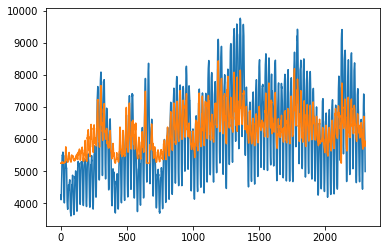

In [69]:
plt.plot(range(len(y_test)), y_test)
plt.plot(range(len(y_test)), pipe.predict(Z_test));

There has to be so relationship betwen date. And hour. Let's convert the date column from a string to a date:

In [73]:
df['date'] = pd.to_datetime(df['date'])

Alternatively, we could import the data with the date column (0th position), already parsed:

In [74]:
df = pd.read_csv('data/weather_power.csv', parse_dates=[0])

We probably want month, weekday and hour:

In [81]:
col = df['date']

pd.concat([col.dt.month, col.dt.weekday, col.dt.hour], axis=1)

,date,date,date
0,1,0,0
1,1,0,1
2,1,0,2
3,1,0,3
4,1,0,4
...,...,...,...
23035,8,0,19
23036,8,0,20
23037,8,0,21
23038,8,0,22


Let's recut the X and y:

In [85]:
target = 'energy_demand'
y = df[target]
X = df[['date', 'temperature']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

We can make a scikit-learn transformer to do this:

In [86]:
from sklearn.base import TransformerMixin

class DateEncoder(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.concat([X.dt.month, X.dt.weekday, X.dt.hour], axis=1)

That way we can apply it on the `X_train` and `X_test` objects:

In [87]:
DateEncoder().fit_transform(X_train['date'])

,date,date,date
0,1,0,0
1,1,0,1
2,1,0,2
3,1,0,3
4,1,0,4
...,...,...,...
20731,5,2,19
20732,5,2,20
20733,5,2,21
20734,5,2,22


Can easily embed it in our mapper framework:

In [89]:
mapper = DataFrameMapper([
    ('date', DateEncoder(), {'input_df': True}),
    (['temperature'], [SimpleImputer(), PolynomialFeatures(degree=2, include_bias=False)])
], df_out=True)

model = LinearRegression()
pipe = make_pipeline(mapper, model)
pipe.fit(X_train, y_train)

Pipeline(steps=[('dataframemapper',
                 DataFrameMapper(df_out=True,
                                 features=[('date',
                                            {'input_df': True}),
                                           (['temperature'],
                                            [SimpleImputer(),
                                             PolynomialFeatures(include_bias=False)])])),
                ('linearregression', LinearRegression())])

Explains even more variance:

In [90]:
pipe.score(X_test, y_test)

0.667215461044525

And shaving off more from RMSE:

In [92]:
mean_squared_error(y_test, pipe.predict(X_test)) ** (1/2)

801.8078829389401

The prediction plot:

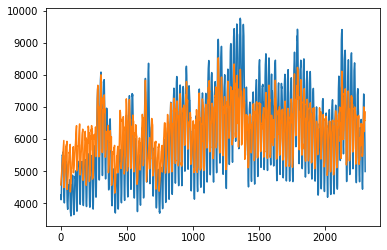

In [94]:
plt.plot(range(len(y_test)), y_test)
plt.plot(range(len(y_test)), pipe.predict(X_test));

Because of the way pickle works, we have move the `DateEncoder` to a `utils.py` file:

In [95]:
%%writefile utils.py

import pandas as pd
from sklearn.base import TransformerMixin

class DateEncoder(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.concat([X.dt.month, X.dt.weekday, X.dt.hour], axis=1)

Overwriting utils.py


Let's write the complete model to a new file:

In [96]:
%%writefile model.py

import pickle
import pandas as pd
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from utils import DateEncoder # CUSTOM IMPORT

df = pd.read_csv('data/weather_power.csv', parse_dates=[0])

target = 'energy_demand'
y = df[target]
X = df[['date', 'temperature']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

mapper = DataFrameMapper([
    ('date', DateEncoder(), {'input_df': True}),
    (['temperature'], [SimpleImputer(), PolynomialFeatures(degree=2, include_bias=False)])
], df_out=True)

model = LinearRegression()
pipe = make_pipeline(mapper, model)
pipe.fit(X_train, y_train)

with open('pipe.pkl', 'wb') as f:
    pickle.dump(pipe, f)

Overwriting model.py


# App 08

Add the custom `DateEncoder` and accept a dictionary in the index, and change it to a post request:

In [97]:
%%writefile app.py

import pickle
import pandas as pd
import uvicorn
from fastapi import FastAPI
from typing import Dict
import os
from utils import DateEncoder

app = FastAPI()

with open('pipe.pkl', 'rb') as f:
    pipe = pickle.load(f)

@app.post('/')
def index(json_data: Dict):
    new = pd.DataFrame({
        'date': [pd.Timestamp(json_data.get('date'))],
        'temperature': [float(json_data.get('temperature'))]
    })
    prediction = pipe.predict(new)[0]
    return {'prediction': prediction}

if __name__ == '__main__':
    uvicorn.run(app)

Overwriting app.py


# Post Carrier Function

Need a post carrier to hit the local endpoint and when it's deployed, this is the function we'll use:

In [98]:
import json
from urllib.request import Request, urlopen
import pandas as pd

def post(url, data):
    data = bytes(json.dumps(data).encode("utf-8"))
    request = Request(
        url=url,
        data=data,
        method="POST"
    )
    request.add_header("Content-type", "application/json; charset=UTF-8")
    with urlopen(request) as response:
        data = json.loads(response.read().decode("utf-8"))
    return data

data = {
    "date": str(pd.Timestamp('now')),
    "temperature": 20
}

# Deploy 04

Deploy on Dokku (Heroku Open Source, and better)


Rerun the model:

```
python model.py
```

Make sure the app works locally:

```
uvicorn app:app --port 5000 --reload
```

Use the post function:

In [99]:
post("http://127.0.0.1:5000", data)

{'prediction': 6009.33851294007}

Once you've confirmed that it still works:

**On Laptop**

1. Push everything up to GitHub:

```
git add .
git commit -m '🚀'
git push
```

**On Server**

2. Spin up a $5 Ubuntu 18.04 server ([DigitalOcean](https://m.do.co/c/2909cd1f3f10) works)...

3. ssh into it:

```
ssh root@165.XXX.43.118
```

4. Update everything:

```
sudo apt update
sudo apt -y upgrade
```

5. Setup firewall:

````
ufw app list
ufw allow OpenSSH
ufw enable
````

6. Add some rules ([source](https://www.digitalocean.com/community/tutorials/how-to-set-up-a-firewall-with-ufw-on-ubuntu-18-04)):

```
sudo ufw default deny incoming
sudo ufw default allow outgoing
sudo ufw allow ssh
sudo ufw allow 22
sudo ufw allow http
sudo ufw allow https
```

7. Install dokku:

```
wget https://raw.githubusercontent.com/dokku/dokku/v0.21.4/bootstrap.sh
sudo DOKKU_TAG=v0.21.4 bash bootstrap.sh
```

8. Navigate to the machine IP address of the server in a browser and add your ssh key

```
# to copy and paste:
cat .ssh/id_rsa.pub
```

9. Add server IPv4 address to the hostname for now:

> 165.XXX.43.118

10. Create a dokku app:

```
dokku apps:create powerapp
```

11. Enable VHOST:

```
dokku domains:enable powerapp
```

**On Laptop**

12. Add dokku as a remote:

```
git remote add dokku dokku@165.XXX.43.118:powerapp
```

13. Verify that the remote got added:

```
git remote -v
```

14. Push it up (for every new change just run these commands):

```
git add .
git commit -m '🤞'
git push dokku master
```

15. Hit the server address (`165.XXX.43.118`) to make sure it works!

16. And test it with the post function: